### Image Filter

Filtering an image is a process of removing unwanted elements from an image. This process is performed using a numerical procedure called convolution.

#### Convolution

Convolution is a numerical process that involves element-wise multiplication of an **Input** image by a **Kernel**. 

<div style="text-align:center">
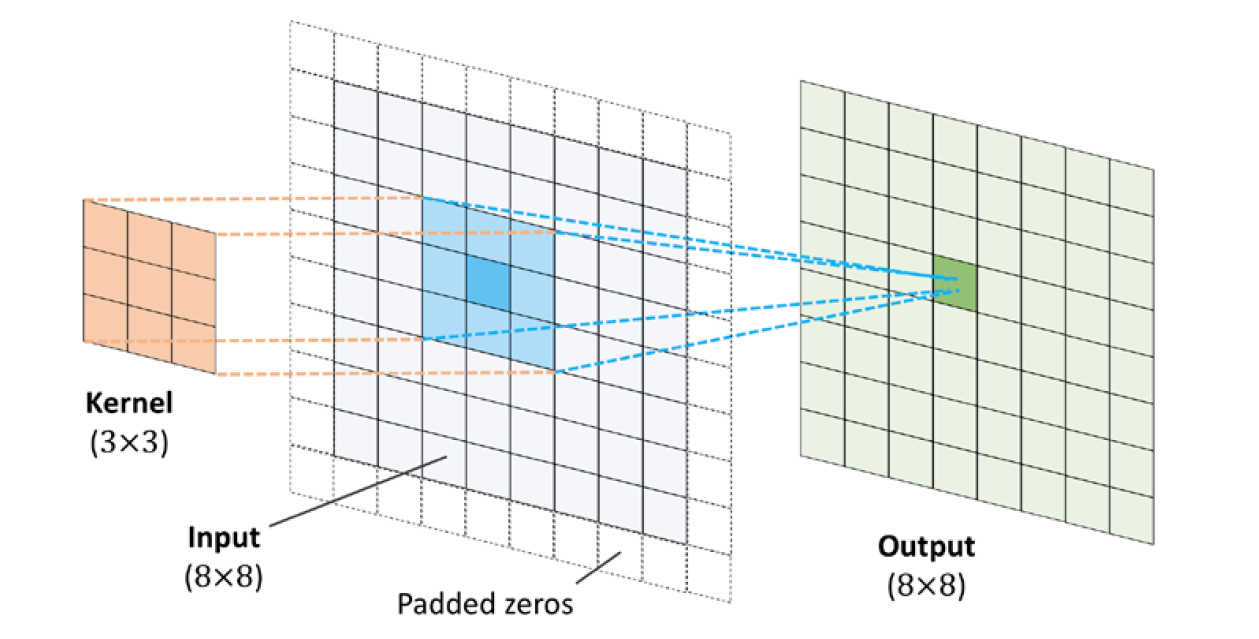
</div>

<div style="text-align:center">
<img src="Convolution_arithmetic_-_Full_padding_no_strides.gif" alt="plot" width="600" />
</div>

| Input     | Kernel | | Output     |
| :---:       |    :----:   |   :---:      |  :---: |
| 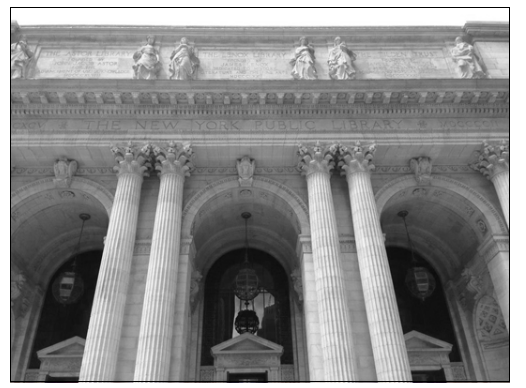     | 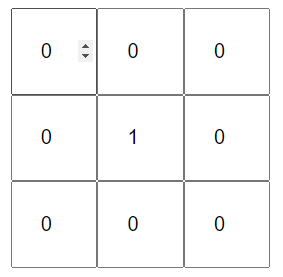| <span style="font-size:4em;">=</span>   | 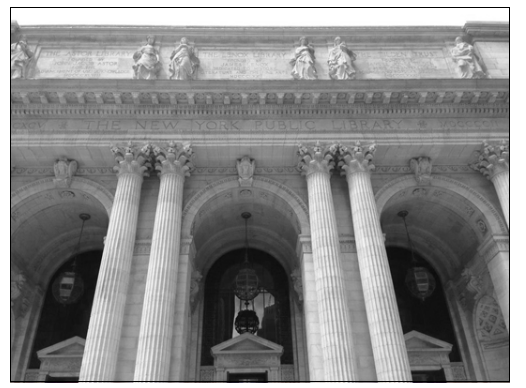   |
| 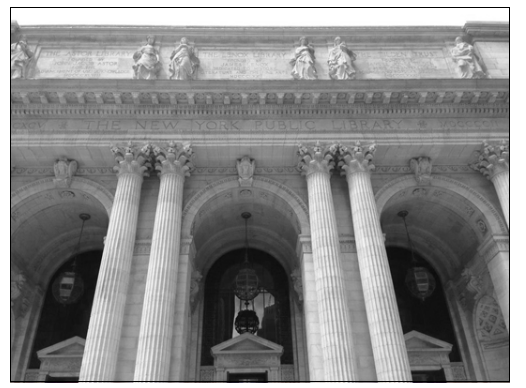     | 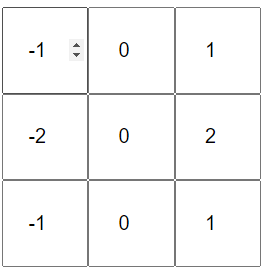| <span style="font-size:4em;">=</span>   | 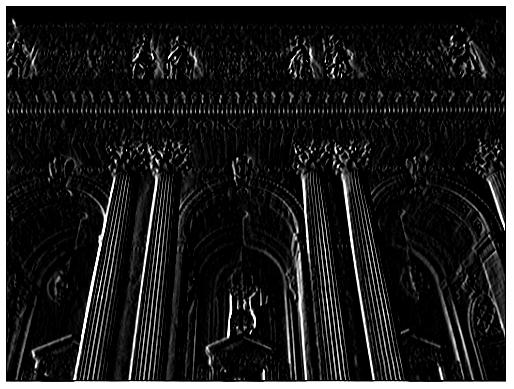  |
| 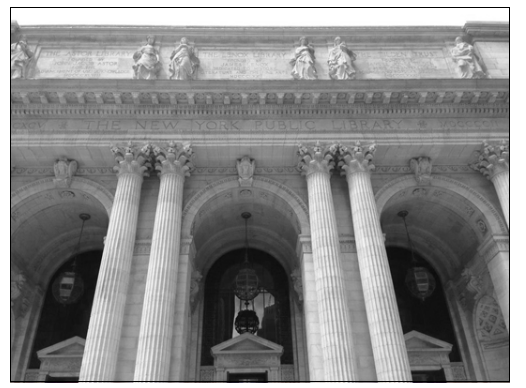     | 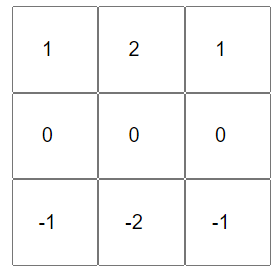| <span style="font-size:4em;">=</span>   | !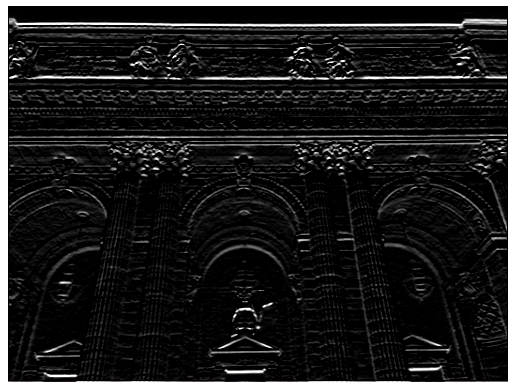 |

### Convolutional Neural Networks (CNN)

The objective of a CNN is to filter images to extract useful information that can be used for classification or regression tasks. However, instead of using pre-defined kernels, CNNs **learn** the kernels using optimization algorithms (such as gradient descent). CNNs have three basic operations:
1) Convolution 
2) non-linerity
3) Pooling

<div style="text-align:center">
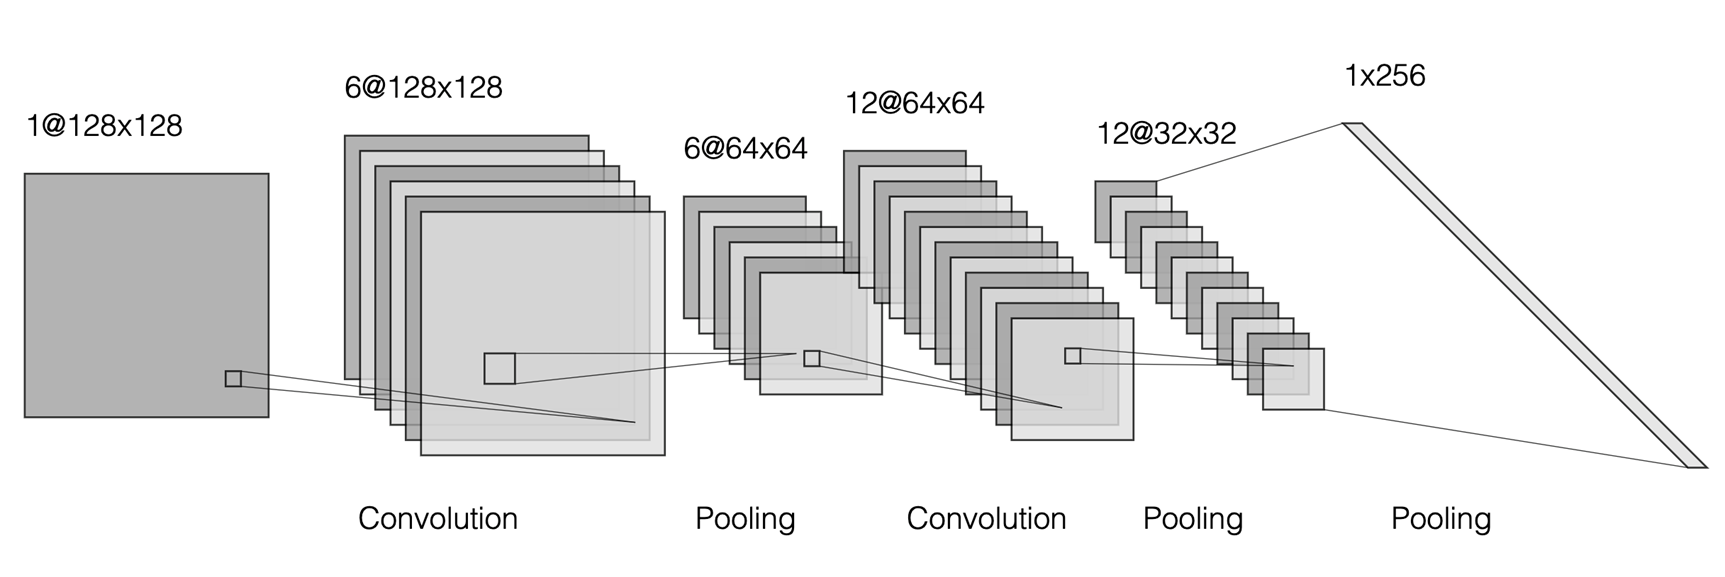
</div>



#### Example

A simple CNN in pytorch to recognize hand-written digits

In [127]:
import torch 
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt

In [128]:
class DatasetTransformer(torch.utils.data.Dataset):

    def __init__(self, data, transform):
        self.data= data
        self.transform = transform

    def __getitem__(self, index):
        #get the image and the label
        img, label= self.data[index]
        return self.transform(img), label

    def __len__(self):
        return len(self.data)

In [129]:
#create dataloaders 
#I alredy downloaded the NMIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

#we are going to transform the image into a pytorch tensor and normalize every image

tfrs = transforms.Compose([transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))])
train_dataset_full = DatasetTransformer(mnist_trainset, tfrs)
test_dataset  = DatasetTransformer(mnist_testset,tfrs)

#select a random subset
idx = list(range(len(train_dataset_full)))
random.shuffle(idx)
train_dataset = torch.utils.data.Subset(train_dataset_full, idx[0:1000])
                                        
batch_size  = 64  # Using minibatches of 64 samples

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

To create a model, we are going to use the ```Conv2d``` function

```python
torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
```

Where
- in_channels -> the number of channels in the image (3 for color, 1 for black and white)
- out_channels -> the number of kernels 


In [130]:
conv = nn.Conv2d(1,5,kernel_size = 3)
input_image = torch.randn(1,1,20,20)
output_image = conv(input_image )
print(f'Input dims = {input_image.shape}, Output dims = {output_image.shape}')

Input dims = torch.Size([1, 1, 20, 20]), Output dims = torch.Size([1, 5, 18, 18])


In [6]:
conv = nn.Conv2d(1,6,kernel_size = 3, padding= 1)
input_image = torch.randn(1,1,20,20)
output_image = conv(input_image )
print(f'Input dims = {input_image.shape}, Output dims = {output_image.shape}')

Input dims = torch.Size([1, 1, 20, 20]), Output dims = torch.Size([1, 6, 20, 20])


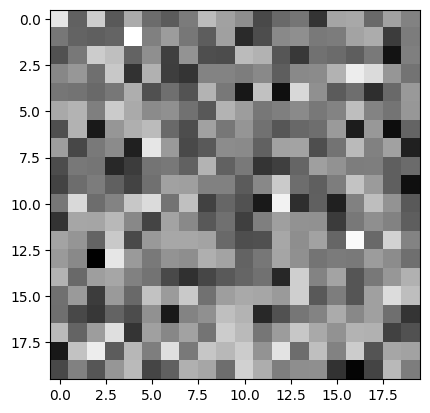

In [7]:
plt.imshow(input_image[0][0].detach(), cmap = 'gray')

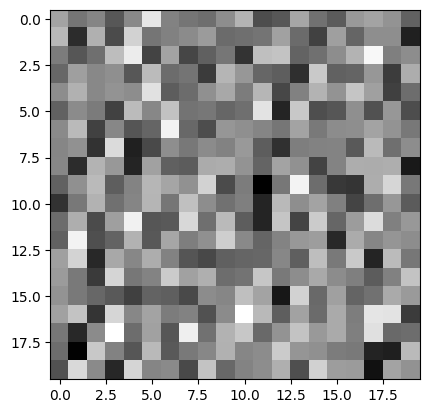

In [8]:
plt.imshow(output_image[0][0].detach(), cmap = 'gray')

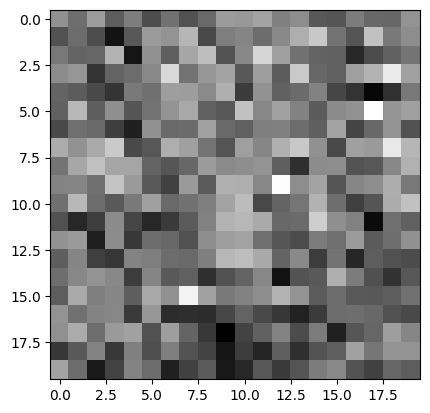

In [9]:
plt.imshow(output_image[0][1].detach(), cmap = 'gray')

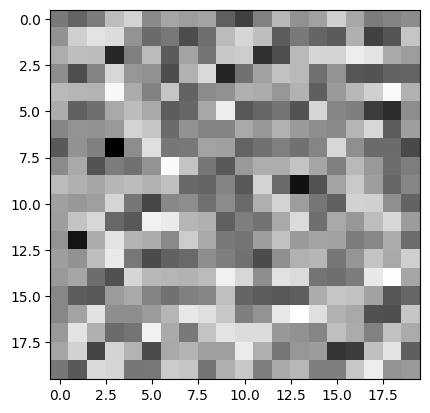

In [10]:
plt.imshow(output_image[0][2].detach(), cmap = 'gray')

In [131]:
## create a model

class ConvolutionalNeuralNetwork_v1(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork_v1, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3)
        self.conv2 = nn.Conv2d(5, 10, kernel_size=5)
        self.maxpool = nn.MaxPool2d(2)
        self.nonlin = nn.ReLU()


    def forward(self, x):
        #first etage
        x = self.conv1(x) #convolution
        x = self.maxpool(x) #max pooling
        x = self.nonlin(x) #nonlinearity
        
        #second etage
        x = self.conv2(x) #convolution
        x = self.maxpool(x) #max pooling
        x = self.nonlin(x) #nonlinearity
        
        #flatten the output
        x = x.view(x.size()[0],-1)
        
        return x

In [137]:
model = ConvolutionalNeuralNetwork_v1()
input_image = torch.randn(1,1,64,64)
output  = model(input_image)
print(f'Input dims = {input_image.shape}, Output dims = {output.shape}')

Input dims = torch.Size([1, 1, 64, 64]), Output dims = torch.Size([1, 1690])


At this point, the CNN is proving us a vector of 160 elements. We can now attach a regulat ANN to the end of the CNN to make the classification into 10 digits 

In [133]:
## create a model

class ConvolutionalNeuralNetwork_v2(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork_v2, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3)
        self.conv2 = nn.Conv2d(5, 10, kernel_size=5)
        self.maxpool = nn.MaxPool2d(2)
        self.nonlin = nn.ReLU()
        
        self.fc1 = nn.Linear(160, 100)
        self.fc2 = nn.Linear(100, 10)
        
        #These variables will help to visualize results
        self.to_show1 = None
        self.to_show2 = None
        self.to_show3 = None

    def forward(self, x):
        #first etage
        x = self.conv1(x) #convolution
        #carry the result
        self.to_show1 = x.clone()
        x = self.maxpool(x) #max pooling
        x = self.nonlin(x) #nonlinearity
        
        
        
        #second etage
        x = self.conv2(x) #convolution
        self.to_show2 = x.clone()
        x = self.maxpool(x) #max pooling
        x = self.nonlin(x ) #nonlinearity
        
        #flatten the output
        x = x.view(x.size()[0],-1)
        
        self.to_show3 = x.clone()
        
        x = self.fc1(x)
        x = self.nonlin(x)
        x = self.fc2(x)
        
        return x

In [134]:
model = ConvolutionalNeuralNetwork_v2()
input_image = torch.randn(1,1,28,28)
output  = model(input_image)
print(f'Input dims = {input_image.shape}, Output dims = {output.shape}')

Input dims = torch.Size([1, 1, 28, 28]), Output dims = torch.Size([1, 10])


In [15]:
input_image = torch.randn(64,1,28,28)
output  = model(input_image)
print(f'Input dims = {input_image.shape}, Output dims = {output.shape}')

Input dims = torch.Size([64, 1, 28, 28]), Output dims = torch.Size([64, 10])


In [135]:
learning_rate = 0.01
num_epochs = 50

loss_fn = nn.CrossEntropyLoss()
 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

loss_test_hist = [0] * num_epochs
accuracy_test_hist = [0] * num_epochs

log_epochs=5

for epoch in range(num_epochs):
    model.train() #set the model for training
    for x_batch, y_batch in train_loader:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        predicted_targets = torch.argmax(pred, dim=1)
        accuracy_hist[epoch] += (predicted_targets == y_batch).sum().item()
        
    loss_hist[epoch] /= len(train_loader.dataset)
    accuracy_hist[epoch] /= len(train_loader.dataset)
    
    
    #compute the testing accuracy 
    with torch.no_grad():
        model.eval() #set the model for evaluation 
        for x_batch, y_batch in test_loader:
            pred_test = model(x_batch)

            predicted_targets = torch.argmax(pred_test, dim=1)
            accuracy_test_hist[epoch] += (predicted_targets == y_batch).sum().item()

            loss_test = loss_fn(pred_test, y_batch)
            loss_test_hist[epoch] += loss_test.item()*y_batch.size(0)
        
        accuracy_test_hist[epoch] /= len(test_loader.dataset)
        loss_test_hist[epoch] /= len(test_loader.dataset)
        
    if epoch % log_epochs==0:
        print(f'Epoch {epoch} Loss {loss_hist[epoch]:.8f}, accuracy  {accuracy_hist[epoch]:0.4f}')
        print(f'        test-Loss {loss_test_hist[epoch]:.8f}, test-accuracy  {accuracy_test_hist[epoch]:0.4f}')

Epoch 0 Loss 1.65296095, accuracy  0.4280
        test-Loss 0.90131382, test-accuracy  0.6986
Epoch 5 Loss 0.13092439, accuracy  0.9560
        test-Loss 0.34985881, test-accuracy  0.9056
Epoch 10 Loss 0.05124824, accuracy  0.9810
        test-Loss 0.35089783, test-accuracy  0.9231
Epoch 15 Loss 0.01808050, accuracy  0.9930
        test-Loss 0.49608880, test-accuracy  0.9090
Epoch 20 Loss 0.03059018, accuracy  0.9910
        test-Loss 0.43164358, test-accuracy  0.9180
Epoch 25 Loss 0.01951844, accuracy  0.9920
        test-Loss 0.56870414, test-accuracy  0.9102
Epoch 30 Loss 0.07492129, accuracy  0.9760
        test-Loss 0.50073287, test-accuracy  0.9134
Epoch 35 Loss 0.00074716, accuracy  1.0000
        test-Loss 0.48677613, test-accuracy  0.9286
Epoch 40 Loss 0.00010216, accuracy  1.0000
        test-Loss 0.47911378, test-accuracy  0.9315
Epoch 45 Loss 0.00006782, accuracy  1.0000
        test-Loss 0.48450671, test-accuracy  0.9323


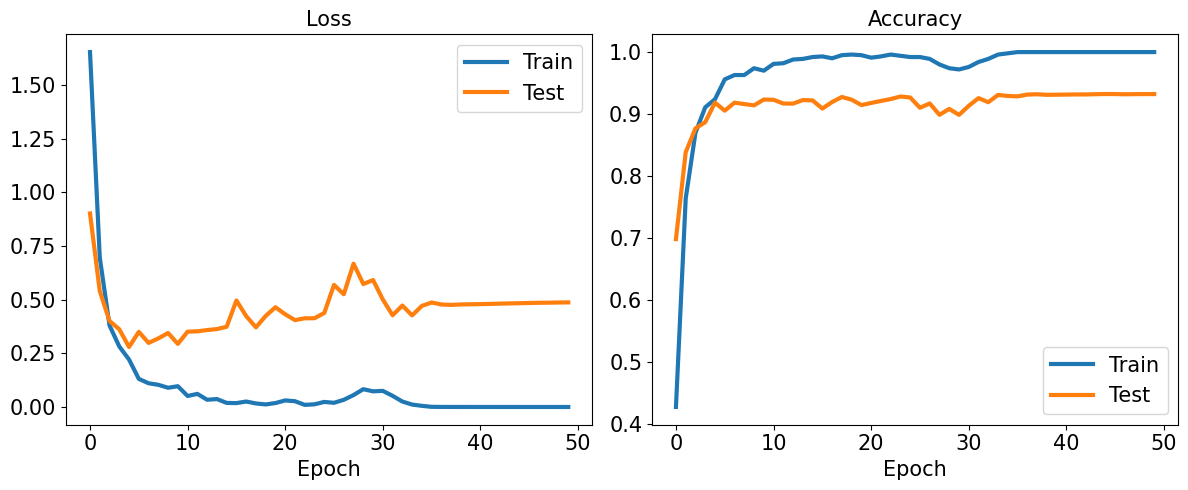

In [136]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3, label='Train')
ax.plot(loss_test_hist, lw=3, label='Test')
ax.set_title('Loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3, label='Train')
ax.plot(accuracy_test_hist, lw=3, label='Test')
ax.set_title('Accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize=15)
plt.tight_layout()

plt.show()

What is the network doing? 

In [18]:
data_test = x_batch
model.eval();
out_test_layer1 = model.conv1(data_test)

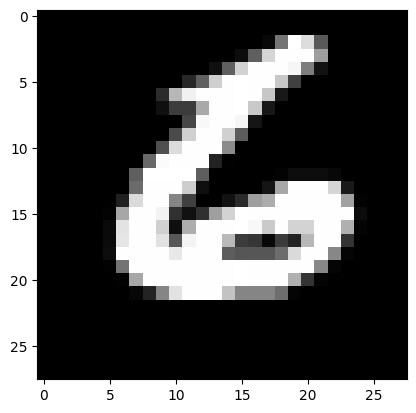

In [19]:
plt.imshow(data_test[15][0].detach(), cmap = 'gray');

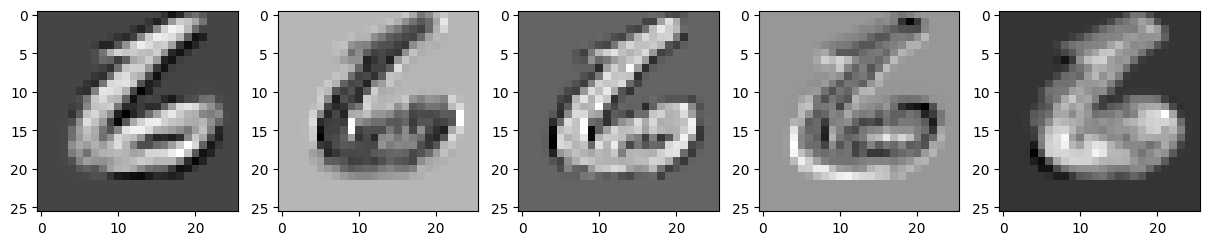

In [20]:
fig,ax = plt.subplots(1,5, figsize=(15,5))
for i in range(5):
    ax[i].imshow(model.to_show1[15][i].detach(), cmap = 'gray')

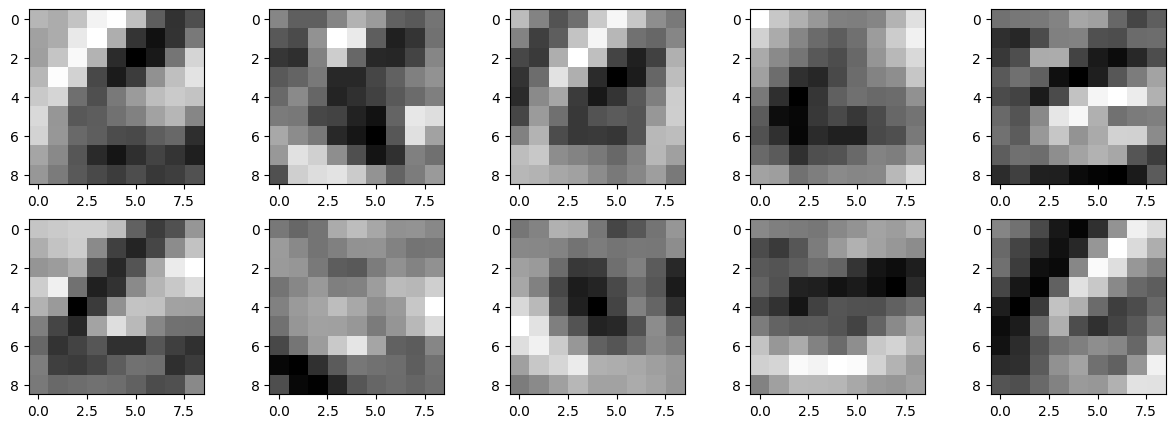

In [21]:
fig,ax = plt.subplots(2,5, figsize=(15,5))
runner = 0 
for j in range(2):
    for i in range(5):
        ax[j,i].imshow(model.to_show2[15][runner].detach(), cmap = 'gray')
        runner+=1

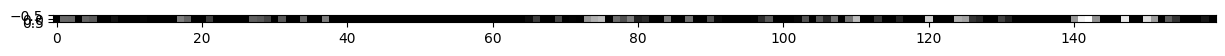

In [22]:
plt.figure(figsize=(15,15))
plt.imshow([model.to_show3[15].detach().numpy()], cmap='gray')

In [27]:
model.to_show3[15].detach().numpy()

array([0.        , 3.6470273 , 3.5634615 , 0.        , 3.4909434 ,
       3.1400416 , 0.        , 0.        , 0.68040407, 0.        ,
       0.        , 0.        , 0.20732701, 0.        , 0.        ,
       0.        , 0.        , 4.400507  , 3.4735515 , 0.        ,
       0.        , 2.156298  , 0.        , 0.        , 0.        ,
       0.        , 0.        , 3.3338265 , 3.0637589 , 2.3106275 ,
       0.        , 3.0299249 , 0.        , 0.        , 3.48795   ,
       0.        , 0.        , 4.30848   , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.474587  , 2.1489155 , 0.        , 0.        , 2.462729  ,
       0.        , 0.12974991, 0.        , 5.261399  , 6.10524

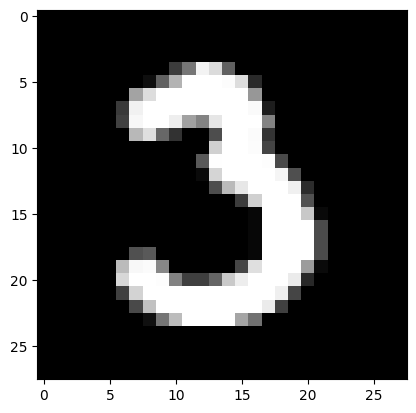

In [23]:
plt.imshow(data_test[12][0].detach(), cmap = 'gray');

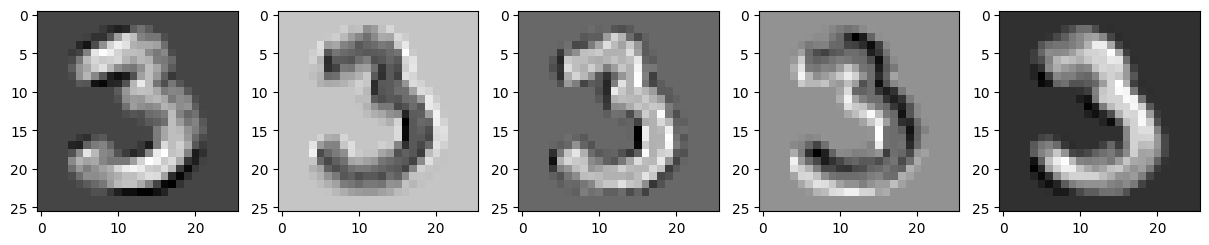

In [24]:
fig,ax = plt.subplots(1,5, figsize=(15,5))
for i in range(5):
    ax[i].imshow(model.to_show1[12][i].detach(), cmap = 'gray')

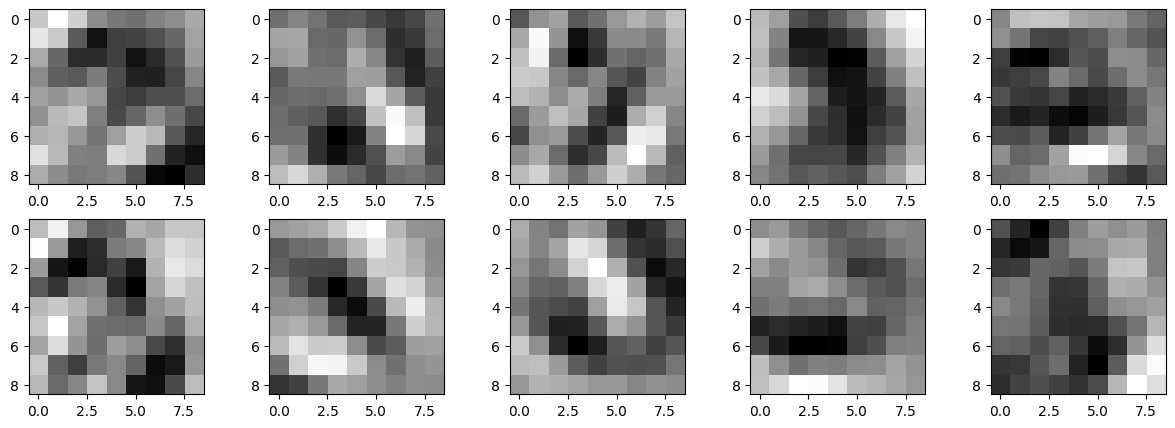

In [25]:
fig,ax = plt.subplots(2,5, figsize=(15,5))
runner = 0 
for j in range(2):
    for i in range(5):
        ax[j,i].imshow(model.to_show2[12][runner].detach(), cmap = 'gray')
        runner+=1

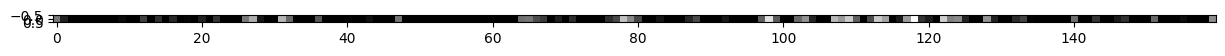

In [26]:
plt.figure(figsize=(15,15))
plt.imshow([model.to_show3[12].detach().numpy()], cmap='gray')

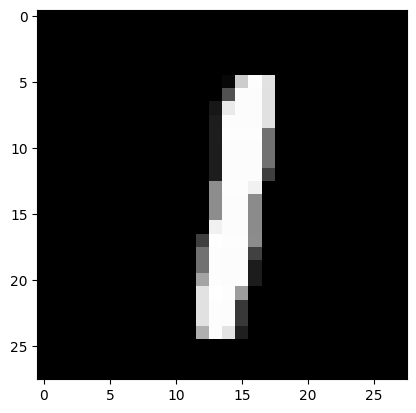

In [28]:
plt.imshow(data_test[0][0].detach(), cmap = 'gray');

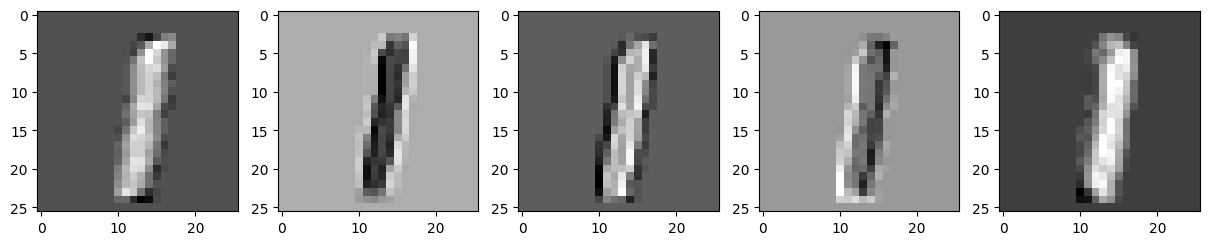

In [29]:
fig,ax = plt.subplots(1,5, figsize=(15,5))
for i in range(5):
    ax[i].imshow(model.to_show1[0][i].detach(), cmap = 'gray')

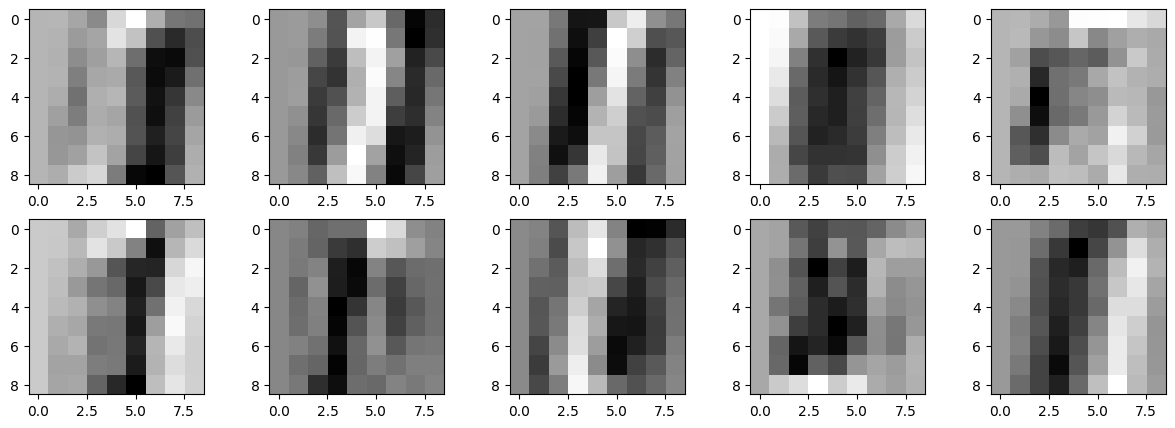

In [30]:
fig,ax = plt.subplots(2,5, figsize=(15,5))
runner = 0 
for j in range(2):
    for i in range(5):
        ax[j,i].imshow(model.to_show2[0][runner].detach(), cmap = 'gray')
        runner+=1

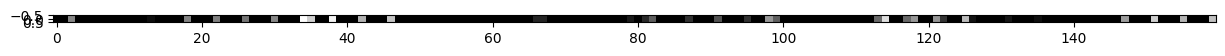

In [31]:
plt.figure(figsize=(15,15))
plt.imshow([model.to_show3[0].detach().numpy()], cmap='gray')

In [72]:
#we can save the model to use it later if you want to detect numbers in images
torch.save(model.state_dict(),'modelNumberId.pt')

## Fine-Tuning 

One of the most interesting aspects of CNN is that they must learn generic aspects of the image to be able to perform classification. Otherwise, they would just overfit the training data and fail when presented with test data (as we saw early). Thus, you can think of CNNs as feature extractors (encoders) that transform the large dimesion image into a *small* dimension set of features, and the last layer of the network takes care of perfoming the final classification task. 

We can exploit this observation, and *re-use* the CNN part of a network to a different (but related) job, and only train the classification layer. This procedure, known as fine-tuning a network often saves time and money as you don't need much data to re-train the classificaiton layer (compared to the amount of data that you would need to train the full network), and it generally produces good results.  



In [142]:
import torchvision
#we will load a new dataset that contains images of clothing items and their labels. 

#Here are the labels 
#                 0: "T-shirt/Top",
#                 1: "Trouser",
#                 2: "Pullover",
#                 3: "Dress",
#                 4: "Coat", 
#                 5: "Sandal", 
#                 6: "Shirt",
#                 7: "Sneaker",
#                 8: "Bag",
#                 9: "Ankle Boot"
labels = ["T-shirt/Top","Trouser",  "Pullover" ,"Dress", "Coat", "Sandal", "Shirt", "Sneaker",  "Bag", "Ankle Boot"]


tfrs = transforms.Compose([transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))])
train_set_full = torchvision.datasets.FashionMNIST("./data", download=True, transform=tfrs)
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=tfrs)  

In [145]:

#create the data loaders 

#select a random subset
idx = list(range(len(train_set_full)))
random.shuffle(idx)
train_set = torch.utils.data.Subset(train_set_full, idx[0:1000])
    

train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=50)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=50)

'T-shirt/Top'

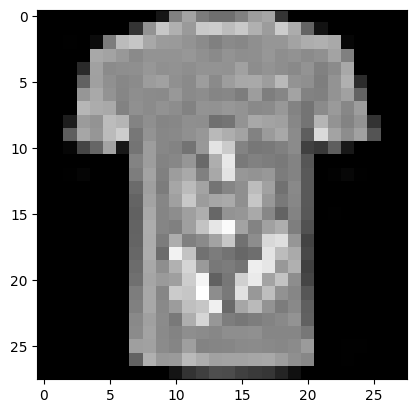

In [146]:
data_from_loader = next(iter(train_loader))
n=0
plt.imshow(data_from_loader[0][n][0].numpy(), cmap='gray')
labels[data_from_loader[1][n].item()]

'Coat'

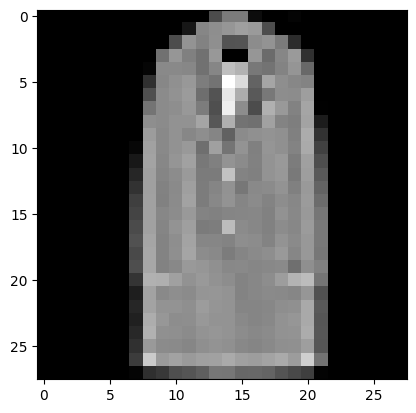

In [147]:
n=30
plt.imshow(data_from_loader[0][n][0].numpy(), cmap='gray')
labels[data_from_loader[1][n].item()]

'Coat'

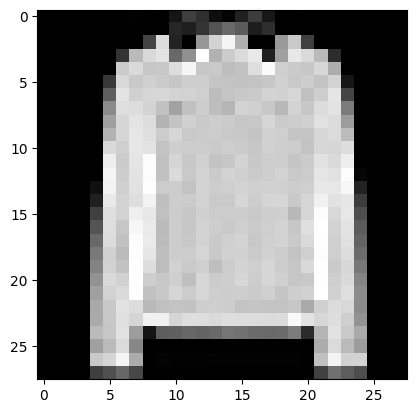

In [148]:
n=45
plt.imshow(data_from_loader[0][n][0].numpy(), cmap='gray')
labels[data_from_loader[1][n].item()]

In [ ]:
#what will happen here? 
n=50
plt.imshow(data_from_loader[0][n][0].numpy(), cmap='gray')
labels[data_from_loader[1][n].item()]

In [140]:
#we will use our previous model, lets create a new instance of the model and re-load its parameters

modelFashion = ConvolutionalNeuralNetwork_v2()
modelFashion.load_state_dict(torch.load('modelNumberId.pt'))

<All keys matched successfully>

In [141]:
#lets use our pre-trained model with the images and see what happens (we can do this as the previous model was also trained to detect one of ten objects)
import numpy as np
modelFashion.eval()
accuracy_test_hist = 0
for x_batch, y_batch in test_loader:
    pred_test = modelFashion(x_batch)

    predicted_targets = torch.argmax(pred_test, dim=1)
    accuracy_test_hist+=(predicted_targets == y_batch).sum().item()

accuracy_test_hist /= len(test_loader.dataset)
print(f'Test Accuracy = {accuracy_test_hist*100 : .4f}%')

Test Accuracy =  8.8900%


In [122]:
#we can train the classifier (only the classifier) again and see what happens 

#We need to freeze the layers that we don't what to train, in this case, the two convolution layers 

print(modelFashion)

ConvolutionalNeuralNetwork_v2(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (nonlin): ReLU()
  (fc1): Linear(in_features=160, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


In [123]:
modelFashion.conv1.requires_grad_(False)
modelFashion.conv2.requires_grad_(False)
modelFashion.fc1.requires_grad_(True)
modelFashion.fc2.requires_grad_(True)

Linear(in_features=100, out_features=10, bias=True)

In [149]:

learning_rate = 0.01
num_epochs = 30

loss_fn = nn.CrossEntropyLoss()
 
optimizer = torch.optim.Adam(modelFashion.parameters(), lr=learning_rate)


loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

loss_test_hist = [0] * num_epochs
accuracy_test_hist = [0] * num_epochs

log_epochs=5



for epoch in range(num_epochs):
    modelFashion.train() #set the model for training
    for x_batch, y_batch in train_loader:
        pred = modelFashion(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        predicted_targets = torch.argmax(pred, dim=1)
        accuracy_hist[epoch] += (predicted_targets == y_batch).sum().item()
        
    loss_hist[epoch] /= len(train_loader.dataset)
    accuracy_hist[epoch] /= len(train_loader.dataset)
    
    
    #compute the testing accuracy 
    with torch.no_grad():
        modelFashion.eval() #set the model for evaluation 
        for x_batch, y_batch in test_loader:
            pred_test = modelFashion(x_batch)

            predicted_targets = torch.argmax(pred_test, dim=1)
            accuracy_test_hist[epoch] += (predicted_targets == y_batch).sum().item()

            loss_test = loss_fn(pred_test, y_batch)
            loss_test_hist[epoch] += loss_test.item()*y_batch.size(0)
        
        accuracy_test_hist[epoch] /= len(test_loader.dataset)
        loss_test_hist[epoch] /= len(test_loader.dataset)
        
    if epoch % log_epochs==0:
        print(f'Epoch {epoch} Loss {loss_hist[epoch]:.8f}, accuracy  {accuracy_hist[epoch]*100:0.4f}%')
        print(f'        test-Loss {loss_test_hist[epoch]:.8f}, test-accuracy  {accuracy_test_hist[epoch]*100:0.4f}%')

Epoch 0 Loss 2.48852803, accuracy  30.8000%
        test-Loss 1.52236878, test-accuracy  48.0500%
Epoch 5 Loss 0.40557545, accuracy  85.7000%
        test-Loss 0.82790094, test-accuracy  74.6700%
Epoch 10 Loss 0.25955355, accuracy  90.5000%
        test-Loss 0.96550515, test-accuracy  75.0400%
Epoch 15 Loss 0.10014707, accuracy  96.9000%
        test-Loss 1.28143986, test-accuracy  74.3800%
Epoch 20 Loss 0.04913514, accuracy  98.6000%
        test-Loss 1.55321671, test-accuracy  75.0500%
Epoch 25 Loss 0.10710756, accuracy  96.1000%
        test-Loss 1.56162099, test-accuracy  73.8100%


In [125]:
torch.save(modelFashion.state_dict(),'modelFashionId.pt')

In [150]:
modelFashion = ConvolutionalNeuralNetwork_v2()
modelFashion.load_state_dict(torch.load('modelFashionId.pt'))
#lets use our pre-trained model with the images and see what happens (we can do this as the previous model was also trained to detect one of ten objects)
import numpy as np
modelFashion.eval()
accuracy_test_hist = 0
for x_batch, y_batch in test_loader:
    pred_test = modelFashion(x_batch)

    predicted_targets = torch.argmax(pred_test, dim=1)
    accuracy_test_hist+=(predicted_targets == y_batch).sum().item()

accuracy_test_hist /= len(test_loader.dataset)
print(f'Test Accuracy = {accuracy_test_hist*100 : .4f}%')

Test Accuracy =  79.9300%
